In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
%matplotlib inline
#%config InlineBackend.figure_format = 'svg' 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import pickle as pkl
import dtreeviz
import imodelsx.process_results
from sklearn.tree import plot_tree
import sys
import numpy as np
import viz
# import llm_tree.data
import imodelsx
import sklearn.tree
sys.path.append('../experiments/')

results_dir = '/home/jxm3/research/prompting/tree-prompt/results/tree-prompt/jun4'
# cache_prompt_features_dir = '/home/jxm3/research/prompting/tree-prompt/cache_prompt_features'

r = imodelsx.process_results.get_results_df(results_dir, use_cached=False)

/home/jxm3/.conda/envs/torch/lib/python3.10/site-packages/langchain/vectorstores/analyticdb.py:20: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.84it/s]


In [2]:
r.head()

,dataset_name,seed,save_dir,model_name,split_strategy,max_depth,num_prompts,checkpoint,checkpoint_prompting,verbalizer_num,...,roc_auc_train,accuracy_cv,balanced_accuracy_cv,roc_auc_cv,accuracy_test,balanced_accuracy_test,roc_auc_test,prompts_list,prompt,feature_names
0,rotten_tomatoes,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,5,1,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,1,...,0.822401,0.792185,0.791317,0.822196,0.787992,0.787992,0.822589,"[ Is the reviewer recommending the movie?, Is...",Is the reviewer recommending the movie?,"[!, ! "", ! ', ! ), ! --, ! ., ! ?, ! a, ! and,..."


In [3]:
r['verbalizer_num'].value_counts()

verbalizer_num
1    1
Name: count, dtype: int64

In [4]:
r.num_prompts.value_counts()

num_prompts
1    1
Name: count, dtype: int64

In [5]:
r['checkpoint'].value_counts()

checkpoint
EleutherAI/gpt-j-6B    1
Name: count, dtype: int64

In [6]:
r['max_depth'].value_counts()

max_depth
5    1
Name: count, dtype: int64

In [7]:
r['seed'].value_counts()

seed
0    1
Name: count, dtype: int64

In [8]:
r[r['checkpoint'] == 'EleutherAI/gpt-j-6B']

,dataset_name,seed,save_dir,model_name,split_strategy,max_depth,num_prompts,checkpoint,checkpoint_prompting,verbalizer_num,...,roc_auc_train,accuracy_cv,balanced_accuracy_cv,roc_auc_cv,accuracy_test,balanced_accuracy_test,roc_auc_test,prompts_list,prompt,feature_names
0,rotten_tomatoes,0,/home/jxm3/research/prompting/tree-prompt/resu...,tprompt,iprompt,5,1,EleutherAI/gpt-j-6B,EleutherAI/gpt-j-6B,1,...,0.822401,0.792185,0.791317,0.822196,0.787992,0.787992,0.822589,"[ Is the reviewer recommending the movie?, Is...",Is the reviewer recommending the movie?,"[!, ! "", ! ', ! ), ! --, ! ., ! ?, ! a, ! and,..."


In [9]:
# select a single model
rd = r[(r['checkpoint'] == 'EleutherAI/gpt-j-6B') & (r['max_depth'] == 5)]
# run_args = rd.iloc[1]
run_args = rd.sort_values(by='accuracy_test', ascending=False).iloc[0]
model_name = run_args.model_name

In [10]:
print(run_args.model_name, '//', run_args.dataset_name, '//', run_args.verbalizer_num)

tprompt // rotten_tomatoes // 1


### Load an individual model

In [11]:
print('acc', run_args.accuracy_test, 'depth', run_args.max_depth, 'dset', run_args.dataset_name)
print('verb:', run_args.verbalizer_num)
model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))

if model_name == 'tprompt':
    dt, feature_names = imodelsx.viz.extract_sklearn_tree_from_llm_tree(model, n_classes=2, dtreeviz_dummies=False)
    print(model)
    print(feature_names)
else:
    dt = model
    feature_names = run_args.feature_names
feat_names = ['\n'.join(n.split(',')) for n in feature_names]

acc 0.7879924953095685 depth 5 dset rotten_tomatoes
verb: 1
> Tree(max_depth=5 split_strategy=iprompt)
> ------------------------------------------------------
PromptStump(val=0.50 n=5715 prompt= Is the reviewer recommending the movie?)
   PromptStump(val=0.49 n=5653 prompt= Is the movie recommended?)
      PromptStump(val=0.15 n=2337 prompt= What is the tone of the reviewer's comments about the movie?)
         PromptStump(val=0.15 n=2288 prompt= What is the overall sentiment of the reviews towards the movie?)
            PromptStump(val=0.15 n=2185 prompt= How would you rate the storytelling flow of the movie?)
               Neg n=2130 val=0.154
               Pos n=55 val=0.164
            PromptStump(val=0.11 n=103 prompt= Based on the given data, classify whether the reviews are positive or negative.)
               Neg n=102 val=0.108
               Pos n=1 val=0.000
         PromptStump(val=0.18 n=49 prompt= How would you rate the movie based on the given data?)
            Pro

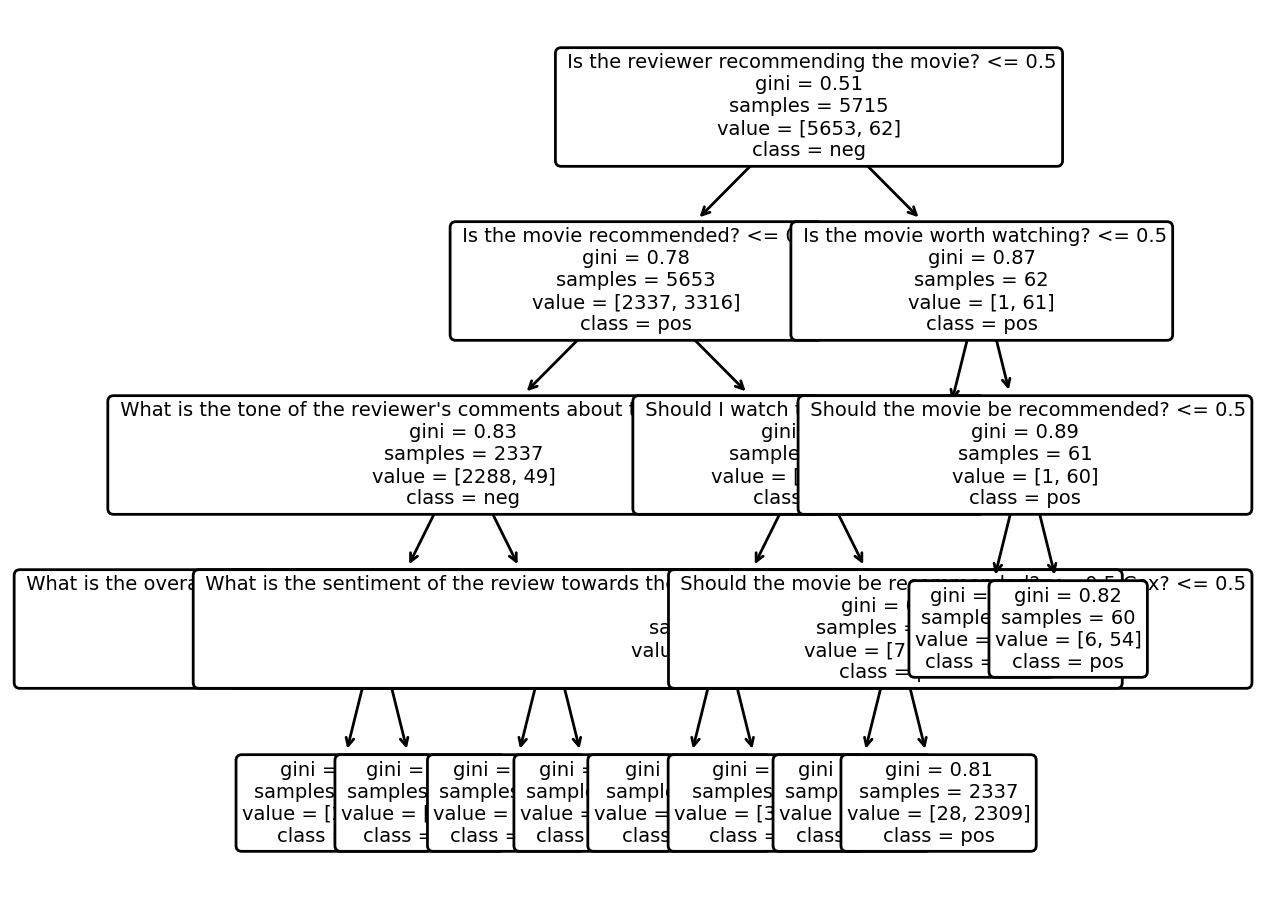

In [12]:
sklearn.tree.plot_tree(dt, feature_names=feat_names, class_names=['neg', 'pos'],
                        precision=2, rounded=True, fontsize=7)
plt.show()